In [6]:
import pandas as pd
import sys
from pathlib import Path
# Set up project root and import paths
project_root = Path.cwd().parents[0]
sys.path.append(str(project_root))

# Import config and generator
from scripts.paths import PROJECT_ROOT, load_config
from scripts.generate_data import generate_dataset 

# Load configuration
config = load_config()
sim_cfg = config["simulation"]

# Generate dataset
df = pd.DataFrame(generate_dataset(
    n=sim_cfg["n_events"],
    Z=sim_cfg["Z"],
    A=sim_cfg["A"],
    b_min=sim_cfg["b_min"],
    b_max=sim_cfg["b_max"],
    layers=sim_cfg["layers"],
    reaction_prob=sim_cfg["reaction_prob"],
    layer_thickness=sim_cfg["layer_thickness"],
    eloss_scaling=sim_cfg["eloss_scaling"]
))

In [7]:
import numpy as np
def apply_energy_smearing(df, resolutions):
    """
    Apply Gaussian smearing to each dE_i column using per-layer resolutions.

    resolutions: float or list of floats (one per layer)
    """
    df_smeared = df.copy()

    dE_cols = [col for col in df.columns if col.startswith("dE_")]

    if isinstance(resolutions, float) or isinstance(resolutions, int):
        resolutions = [resolutions] * len(dE_cols)

    assert len(resolutions) == len(dE_cols), "Resolution list must match number of dE columns"

    for i, col in enumerate(dE_cols):
        sigma = df[col] * resolutions[i]
        noise = np.random.normal(0, sigma)
        df_smeared[col] += noise

    return df_smeared

In [8]:
# Load resolution config
det_cfg = config["detector"]
res = det_cfg["energy_resolution"]

# Apply smearing
df_smeared = apply_energy_smearing(df, resolutions=res)

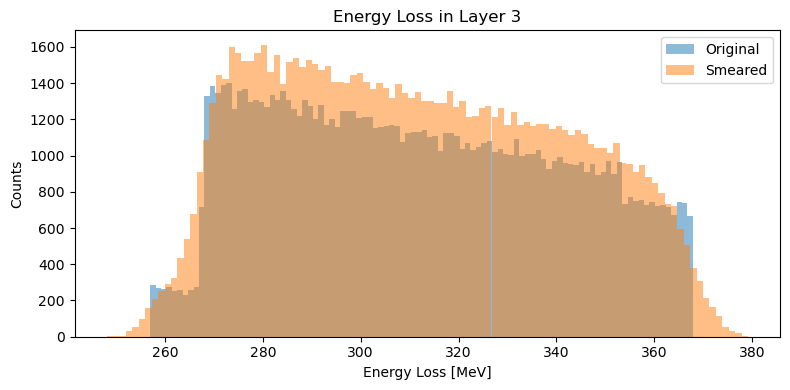

In [4]:
import matplotlib.pyplot as plt

layer = 2  # for example, dE_3
plt.figure(figsize=(8, 4))
plt.hist(df[f'dE_{layer+1}'], bins=100, alpha=0.5, label="Original")
plt.hist(df_smeared[f'dE_{layer+1}'], bins=100, alpha=0.5, label="Smeared")
plt.title(f"Energy Loss in Layer {layer+1}")
plt.xlabel("Energy Loss [MeV]")
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Save datasets
raw_path = PROJECT_ROOT / config["paths"]["output_data_raw"]
smeared_path = PROJECT_ROOT / config["paths"]["output_data_smeared"]

df.to_csv(raw_path, index=False)
df_smeared.to_csv(smeared_path, index=False)

print(f"Raw data saved to: {raw_path}")
print(f"Smeared data saved to: {smeared_path}")


Raw data saved to: /home/wimmer/projects/LISA/MLISA/data/raw/simulated_data.csv
Smeared data saved to: /home/wimmer/projects/LISA/MLISA/data/processed/simulated_data_smeared.csv
